<a href="https://colab.research.google.com/github/mattiasthalen/Bayesian-Velocity-Profiling/blob/main/Bayesian_Velocity_Profiling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian Velocity Profiling

## Setup Environment


### Load Libraries

In [58]:
import time
import pint_xarray
import warnings
import os
import jax
import numpyro

import sklearn.preprocessing
import sklearn.metrics
import pymc.sampling_jax

import pymc as pm
import pandas as pd
import numpy as np
import arviz as az
import xarray as xr

from collections import OrderedDict
from urllib.parse import unquote

from urllib.parse import unquote
from matplotlib import pyplot as plt

from typing import Callable, Optional, Dict, List, Union, NoReturn

### Set Global Vars

In [59]:
import warnings
warnings.filterwarnings("ignore")

In [60]:
numpyro.util.set_platform('cpu')
n_devices = len(jax.devices())
numpyro.util.set_host_device_count(n_devices)

In [61]:
hdi_prob = 0.9

csv_path = 'https://raw.githubusercontent.com/mattiasthalen/Bayesian-Velocity-Profiling/main/RepOne_Data_Export.csv'

plt.style.use('bmh')

## Functions

### ETL Functions

In [62]:
def extract(csv_path, **kwargs):
    df = pd.read_csv(csv_path)

    df.columns = (df.columns
                    .str.lower()
                    .str.replace(' \(m/s\)', '')
                    .str.replace(' \(mm\)', '')
                    .str.replace(' \(sec\)', '')
                    .str.replace(' \(%\)', '')
                    .str.replace(' ', '_'))
        
    df.rename(columns = {'weight': 'load'}, inplace = True)

    df['workout_start_time'] = pd.to_datetime(df['workout_start_time'], format = '%d/%m/%Y, %H:%M:%S')

    df.dropna(subset = ['exercise'], inplace = True)
    df['rest_time'] = pd.to_timedelta(df['rest_time'])

    # Correct split session
    df['set'].mask((df['exercise'] == 'deadlift') & (df['workout_start_time'] == pd.to_datetime('2020-12-30 13:06:04')), df['set'] + 7, inplace = True)
    df.replace({'workout_start_time': pd.to_datetime('2020-12-30 13:06:04')}, pd.to_datetime('2020-12-30 12:53:09'), inplace = True)
    df.replace({'workout_start_time': pd.to_datetime('2021-01-07 11:50:22')}, pd.to_datetime('2021-01-07 11:20:07'), inplace = True)
    df.replace({'workout_start_time': pd.to_datetime('2021-06-10 12:02:22')}, pd.to_datetime('2021-06-10 11:56:31'), inplace = True)
    df.replace({'workout_start_time': pd.to_datetime('2021-06-14 12:06:00')}, pd.to_datetime('2021-06-14 11:57:50'), inplace = True)

    # Reindex sets & reps to counter bugs in the extract
    df['set'] = df.groupby(['exercise', 'workout_start_time'])['set'].apply(lambda x: (x != x.shift()).cumsum() - 1)
    df['rep'] = df.groupby(['exercise', 'workout_start_time', 'set']).cumcount()

    # Convert from , to . as decimal sign
    df['load'] = df['load'].str.replace(',', '.').astype('float')

    # Drop rows with tag fail
    fail_filter = df['tags'].str.contains('fail', na = False)
    df = df[~fail_filter]

    # Handle the case when a rep is split into two reps
    rep_split_filter = df['tags'].str.contains('rep split', na = False)

    rep_split_df = df[rep_split_filter].groupby(['exercise', 'workout_start_time', 'set', 'load', 'metric'])[['range_of_motion', 'duration_of_rep']].sum()
    rep_split_df['avg_velocity'] = rep_split_df['range_of_motion']/1000/rep_split_df['duration_of_rep']
    rep_split_df['rep'] = 0
    rep_split_df.reset_index(inplace = True)

    rep_split_df = rep_split_df.groupby(['exercise', 'workout_start_time', 'set', 'rep']).max()

    df = pd.concat([df[~rep_split_filter], rep_split_df])

    # Group to get multi index
    df = df.groupby(['exercise', 'workout_start_time', 'set', 'rep']).max()

    return df

In [63]:
def transform(df, **kwargs):
    # Convert to xarray
    ds = df.to_xarray()

    # Change Set and Rep to integers
    ds['set'] = ds['set'].astype(int)
    ds['rep'] = ds['rep'].astype(int)

    # Move variables to coords
    ds = ds.set_coords(['metric', 'tags'])

    # Define UOMs
    ds = ds.pint.quantify({'load': 'kg',
                            'avg_velocity': 'meter / second',
                            'peak_velocity': 'meter / seconds',
                            'range_of_motion': 'mm',
                            'duration_of_rep': 's'})

    # Session meta data
    session_stack = ['exercise', 'workout_start_time']
    ds['session_max_load'] = ds['load'].stack(stack = session_stack)\
                                        .groupby('stack')\
                                        .reduce(all_nan_max, ...)\
                                        .unstack()

    # Set meta data
    set_stack = [*session_stack, 'set']
    ds['load'] = (ds['load'].stack(stack = set_stack)
                            .groupby('stack')
                            .reduce(all_nan_max, ...)
                            .unstack())

    ds['reps'] = (ds['avg_velocity'].stack(stack = set_stack)
                                    .groupby('stack')
                                    .count(...)
                                    .unstack()
                                    .where(ds['load'] > 0, drop = True))

    ds['set_velocities'] = summarize(ds['avg_velocity'].pint.dequantify())
    ds['set_velocities'] = ds['set_velocities'].pint.quantify({ds['set_velocities'].name: 'mps'})

    ds.coords['set_type'] = assign_set_type(ds['load'])

    # Add the running min top set velocity per exercise
    ds['minimum_velocity_threshold'] = (ds['set_velocities'].sel({'aggregation': 'first'})
                                                            .where(ds.coords['set_type'] == 'Top Set')
                                                            .pint.dequantify()
                                                            .stack(stack = session_stack)
                                                            .groupby('stack')
                                                            .reduce(all_nan_min, ...)
                                                            .unstack()
                                                            .rolling({'workout_start_time': len(ds['workout_start_time'])},
                                                                    min_periods = 1)
                                                            .min())
    ds['minimum_velocity_threshold'] = ds['minimum_velocity_threshold'].pint.quantify({ds['minimum_velocity_threshold'].name: 'meter / second'})

    # Add running max load per exercise
    ds['rolling_max_load'] = (ds['load'].pint.dequantify()
                                        .stack(stack = session_stack)
                                        .groupby('stack')
                                        .reduce(all_nan_max, ...)
                                        .unstack()
                                        .rolling({'workout_start_time': len(ds['workout_start_time'])},
                                                min_periods = 1)
                                        .max())
    ds['rolling_max_load'] = ds['rolling_max_load'].pint.quantify({ds['rolling_max_load'].name: 'kg'})

    # Additional session meta data
    ds['workup_sets'] = ds['load'].where(ds.coords['set_type'] == 'Work Up', drop = True)\
                                    .stack(stack = session_stack)\
                                    .groupby('stack')\
                                    .count(...)\
                                    .unstack()

    #ds['session_regression_coefficients'] = linear_fit(ds, 'load', 'set_velocities', 'set')

    #ds['estimated_1rm'] = linear_predict(ds['minimum_velocity_threshold'].pint.dequantify(), ds['session_regression_coefficients'])
    #ds['estimated_1rm'] = ds['estimated_1rm'].pint.quantify({ds['estimated_1rm'].name: 'kg'})

    #ds['zero_velocity_load'] = linear_predict(0, ds['session_regression_coefficients'])
    #ds['zero_velocity_load'] = ds['zero_velocity_load'].pint.quantify({ds['zero_velocity_load'].name: 'kg'})

    #ds['zero_load_velocity'] = linear_predict(0, ds['session_regression_coefficients'], reverse = True)
    #ds['zero_load_velocity'] = ds['zero_load_velocity'].pint.quantify({ds['zero_load_velocity'].name: 'mps'})

    #ds['curve_score'] = ds['zero_velocity_load'].pint.dequantify()*ds['zero_load_velocity'].pint.dequantify()/2

    ds['session_volume'] = (ds['load'] * ds['reps']).stack(stack = session_stack).groupby('stack').sum(...).unstack()
    #ds['session_relative_volume'] = ds['session_volume']/ds['estimated_1rm']

    # Rep meta data
    #ds['rep_exertion'] = linear_predict(ds['avg_velocity'].pint.dequantify(), ds['session_regression_coefficients'])/ds['estimated_1rm'].pint.dequantify()
    #ds['rep_force'] = (ds['load']*ds['range_of_motion'].pint.to('meter')/ds['duration_of_rep']**2).pint.to('N')
    #ds['rep_energy'] = (ds['rep_force']*ds['range_of_motion'].pint.to('meter')).pint.to('J')

    # Session meta data
    #ds['session_exertion_load'] = ds['rep_exertion'].stack(stack = ['exercise', 'workout_start_time']).groupby('stack').reduce(all_nan_sum, ...).unstack().pint.dequantify()

    # Add PR coordinates
    ds.coords['max_load_pr_flag'] = ds['rolling_max_load'].diff('workout_start_time') > 0
    ds.coords['max_load_pr_flag'] = ds.coords['max_load_pr_flag'].fillna(0).astype(int)

    # Add indexing for inference
    session_shape = [ds.dims[i] for i in session_stack]
    ds.coords['session'] = (session_stack, np.arange(np.prod(session_shape)).reshape(session_shape))

    observation_shape = [ds.dims[i] for i in set_stack]
    ds.coords['observation'] = (set_stack, np.arange(np.prod(observation_shape)).reshape(observation_shape))

    return ds

In [64]:
def load(csv_path, **kwargs):
    df = extract(csv_path, **kwargs)
    ds = transform(df, **kwargs)

    return ds

### Model Functions

In [65]:
def build_model(velocity,
                load,
                session_idx,
                session_exercise_idx,
                coords,
                render_model = True,
                **kwargs):
    
    with pm.Model() as model:
        
        # Add coordinates
        model.add_coord(name = 'observation',
                        values = coords['observation'],
                        mutable = True)
        
        model.add_coord(name = 'exercise',
                        values = coords['exercise'],
                        mutable = False)
        
        model.add_coord(name = 'session',
                        values = coords['session'],
                        mutable = False)

        # Add inputs
        velocity = pm.MutableData(name = 'velocity',
                                value = velocity,
                                dims = 'observation')

        session_idx = pm.MutableData(name = 'session_idx',
                                     value = session_idx,
                                     dims = 'observation')

        # Global Parameters
        intercept_global = pm.Normal(name = 'intercept_global',
                                        mu = 0.0,
                                        sigma = 1.0)
        
        intercept_sigma_global = pm.HalfNormal(name = 'intercept_sigma_global',
                                                sigma = 1.0)
        
        slope_global = pm.HalfNormal(name = 'slope_global',
                                        sigma = 1.0)
        
        curve_global = pm.HalfNormal(name = 'curve_global',
                                        sigma = 1.0)
        
        error_global = pm.HalfNormal(name = 'error_global',
                                        sigma = 1.0)
        
        # Exercise Parameters
        intercept_offset_exercise = pm.Normal(name = 'intercept_offset_exercise',
                                                mu = 0.0,
                                                sigma = 1.0,
                                                dims = 'exercise')
        
        intercept_exercise = pm.Deterministic(name = 'intercept_exercise',
                                                var = intercept_global + intercept_sigma_global*intercept_offset_exercise,
                                                dims = 'exercise')
        
        intercept_sigma_exercise = pm.HalfNormal(name = 'intercept_sigma_exercise',
                                                    sigma = 1.0,
                                                    dims = 'exercise')
        
        slope_exercise = pm.HalfNormal(name = 'slope_exercise',
                                        sigma = slope_global,
                                        dims = 'exercise')
        
        curve_exercise = pm.HalfNormal(name = 'curve_exercise',
                                        sigma = curve_global,
                                        dims = 'exercise')

        # Session Parameters
        intercept_offset_session = pm.Normal(name = 'intercept_offset_session',
                                                mu = 0.0,
                                                sigma = 1.0,
                                                dims = 'session')

        intercept_session = pm.Deterministic(name = 'intercept_session',
                                                var = (intercept_exercise[session_exercise_idx]
                                                        + intercept_sigma_exercise[session_exercise_idx]
                                                        * intercept_offset_session),
                                                dims = 'session')
        
        slope_session = pm.HalfNormal(name = 'slope_session',
                                        sigma = slope_exercise[session_exercise_idx],
                                        dims = 'session')

        curve_session = pm.HalfNormal(name = 'curve_session',
                                        sigma = curve_exercise[session_exercise_idx],
                                        dims = 'session')
        
        # Final Parameters
        intercept = intercept_session[session_idx]
        slope = slope_session[session_idx]
        curve = curve_session[session_idx]
        error = error_global

        # Estimated Value
        load_mu = pm.Deterministic(name = 'mu',
                                    var = intercept - slope*velocity - curve*velocity**2,
                                    dims = 'observation')

        # Likelihood
        load_likelihood = pm.Normal(name = 'load',
                                    mu = load_mu,
                                    sigma = error,
                                    observed = load,
                                    dims = 'observation')
        
    if render_model:
        display(pm.model_to_graphviz(model))
        
    return model

In [66]:
def sample(model,
           prior_predictive = True,
           posterior_predictive = True,
           sampler = 'pymc',
           sampler_kwargs = None,
           prior_kwargs = None,
           post_pred_kwargs = None,
           **kwargs):

    if sampler_kwargs is None:
        sampler_kwargs = {}

    if prior_kwargs is None:
        prior_kwargs = {}

    if post_pred_kwargs is None:
        post_pred_kwargs = {}

    if sampler == 'pymc':
        sampler_fn = pm.sample
    
    if sampler == 'numpyro':
        sampler_fn = pm.sampling_jax.sample_numpyro_nuts
    
    if sampler == 'blackjax':
        sampler_fn = pm.sampling_jax.sample_blackjax_nuts

    with model:
        inference_data = sampler_fn(**sampler_kwargs)
        
        if prior_predictive:
            inference_data.extend(pm.sample_prior_predictive(**prior_kwargs))

        if posterior_predictive:
            inference_data.extend(pm.sample_posterior_predictive(trace = inference_data, **post_pred_kwargs))

    return inference_data

### Plotting Functions

In [67]:
def plot_last_session(exercises):
    n_exercises = len(exercises)

    n_rows = np.ceil(n_exercises / 2).astype(int)
    n_cols = n_exercises - n_rows

    fig, axes = plt.subplots(n_rows, n_cols, figsize = (15, 10), sharex = True, sharey = True)

    axes = axes.flatten()

    for i, ax in enumerate(axes):

        exercise = exercises[i]

        last_session = regr_data[regr_data['exercise'] == exercise]['session'].max()
        last_session_observations = regr_data[regr_data['session'] == last_session]['observation'].values

        last_session_idata = inference_data.sel(observation = last_session_observations, session = last_session, exercise = exercise)

        az.plot_lm(idata = last_session_idata,
                x = 'velocity',
                y = 'load',
                y_hat = 'load',
                y_model = 'mu',
                kind_pp = 'hdi',
                kind_model = 'hdi',
                y_kwargs = {'marker': '.',
                            'markersize': 9,
                            'color': '#0571b0',
                            'label': 'Observed Data',
                            'zorder': 3},
                y_hat_fill_kwargs = {'fill_kwargs': {'zorder': 0,
                                                        'alpha': 0.6},
                                        'color': '#92c5de',
                                        'hdi_prob': hdi_prob},
                y_model_mean_kwargs = {'zorder': 2,
                                        'color': '#ca0020',
                                        'linewidth': 1,
                                        'linestyle': 'dashed'},
                y_model_fill_kwargs = {'zorder': 1,
                                        'color': '#f4a582',
                                        'alpha': 0.6,
                                        #'fill_kwargs': {'zorder': 1},
                                        #'hdi_kwargs': {'hdi_prob': hdi_prob}
                                        },
                legend = False,
                axes = ax)
        
        ax.set_title(exercise.title(), fontweight = 'bold')
        ax.set_xlabel('Velocity', fontweight = 'bold')
        ax.set_ylabel('Load', fontweight = 'bold')
        ax.legend(loc = 'upper right')

    fig.suptitle('LAST SESSION PER EXERCISE',
                fontweight = 'bold',
                fontsize = 'x-large')

    plt.draw()

In [68]:
def plot_pbc(ds, exercise, data_var, window = 20, signal_window = 8, ax = None, **kwargs):
    df = ds[data_var].sel({'exercise': exercise}, drop = True)\
                     .drop_vars(['training_cycle', 'cycle_type', 'max_weight_pr_flag'])\
                     .to_dataframe()\
                     .dropna()
    
    df['moving_average'] = df[data_var].sort_index(ascending = False)\
                                       .rolling(window, min_periods = 1)\
                                       .mean()
    
    df['moving_range'] = df[data_var].diff(-1)\
                                     .abs()\
                                     .sort_index(ascending = False)\
                                     .rolling(window, min_periods = 1)\
                                     .mean()

    df['process_average'] = df['moving_average']
    df['process_range'] = df['moving_range']
    df['signal'] = None
    df['signal_min'] = None
    df['signal_max'] = None
    df['signal_above_average'] = None
    df['signal_below_average'] = None

    n_rows = len(df)
    previous_signal_id = 0

    for row in np.arange(n_rows):
        first_row = row == 0
        sufficient_rows_left = n_rows - row >= window

        signal_start_id = np.max([8, row - signal_window])

        df['signal_min'][row] = df[data_var][signal_start_id:row].min()
        df['signal_max'][row] = df[data_var][signal_start_id:row].max()

        df['signal_above_average'][row] = (df['signal_min'][row] > df['process_average'][row - 1])
        df['signal_below_average'][row] = (df['signal_max'][row] < df['process_average'][row - 1])

        signal_open = (first_row) | (row >= previous_signal_id + window)
        signal = (signal_open) & (sufficient_rows_left) & (first_row | df['signal_above_average'][row] | df['signal_below_average'][row])
        df['signal'][row] = signal
        
        df['process_average'][row] =  df['process_average'][row - 1]
        df['process_range'][row] =  df['process_range'][row - 1]

        if signal:
            previous_signal_id = row
            df['process_average'][row] =  df['moving_average'][row]
            df['process_range'][row] =  df['moving_range'][row]
        else:
            df['process_average'][row] =  df['process_average'][row - 1]
            df['process_range'][row] =  df['process_range'][row - 1]

    df['lower_limit_1'] = df['process_average'] - df['process_range']/1.128
    df['upper_limit_1'] = df['process_average'] + df['process_range']/1.128
    df['lower_limit_2'] = df['process_average'] - df['process_range']*2/1.128
    df['upper_limit_2'] = df['process_average'] + df['process_range']*2/1.128
    df['lower_limit_3'] = df['process_average'] - df['process_range']*3/1.128
    df['upper_limit_3'] = df['process_average'] + df['process_range']*3/1.128

    if ax is None:
        ax = plt.gca()

    ax.scatter(df.index, df[data_var], marker = '.', alpha = 0.6)
    ax.plot(df.index, df['process_average'])
    ax.plot(df.index, df['lower_limit_3'])
    ax.plot(df.index, df['upper_limit_3'])

    ax.fill_between(df.index,df['lower_limit_1'], df['upper_limit_1'], alpha = 0.3)

    ax.set_xlabel('')
    ax.set_ylabel('')
    #ax.set_ylim([0, None])
    ax.tick_params(labelrotation = 90)
    ax.grid()

    return ax

In [69]:
def plot_kpis(ds, exercise, vars, **kwargs):
    var_titles = [var.title().replace('_', ' ').replace('1Rm', '1RM') for var in vars]

    n_vars = len(vars)

    n_cols = 1

    if n_vars > 1:
        n_cols = 2
    
    n_rows = 1

    if n_vars > 2:
        n_rows = np.ceil(n_vars/n_cols).astype(int)
    
    figsize = np.array([6, 3]) * [n_cols, n_rows]

    fig, axes = plt.subplots(ncols = n_cols,
                            nrows = n_rows,
                            constrained_layout = True,
                            figsize = figsize,
                            sharex = True)
    
    axes = [ax for row in axes for ax in row]

    for key, val in enumerate(vars):
        plot_pbc(ds, exercise, vars[key], ax = axes[key])
        title = var_titles[key]
        axes[key].set_title(title)

    fig.suptitle(f'{exercise.title()} KPIs', fontsize = 16)
    fig.supxlabel('Workout Start Time')

    plt.draw()

### Miscellaneous Functions

In [70]:
def assign_set_type(da, **kwargs):
    set_category = xr.where(da['set'] < da.idxmax('set'), 'Work Up', np.nan)
    set_category = xr.where(da['set'] == da.idxmax('set'), 'Top Set', set_category)
    set_category = xr.where(da['set'] > da.idxmax('set'), 'Back Off', set_category)
    set_category = xr.where(np.isnan(da), np.nan, set_category)
    
    return set_category

In [71]:
def agg_summarize(x, **kwargs):
    x = x[np.isfinite(x)]

    if len(x) > 0:
        min = np.min(x)
        max = np.max(x)
        first = x[0]
        last = x[-1]
        peak_end = np.mean([min, last])
        mean = np.mean(x)
        median = np.median(x)
        hdi = az.hdi(x)
        result = np.array([min, max, first, last, peak_end, mean, median, *hdi])
    else:
        result = np.array([np.nan]*9)
    
    return result

def summarize(x, reduce_dim = 'rep', **kwargs):
    summaries = xr.apply_ufunc(agg_summarize,
                               x,
                               vectorize = True,
                               input_core_dims = [[reduce_dim]],
                               output_core_dims = [['aggregation']])
    
    summaries['aggregation'] = ['min', 'max', 'first', 'last', 'peak_end', 'mean', 'median', 'hdi_lower', 'hdi_upper']
    
    return summaries

In [72]:
def agg_hdi_summary(x, **kwargs):
    mean = x.mean()
    median = np.median(x)
    hdi = az.hdi(x)

    return np.array([mean, median, *hdi])

def hdi_summary(x, reduce_dim = 'sample', **kwargs):
    try:
        x = x.pint.dequantify()
    except:
        pass

    summaries = xr.apply_ufunc(agg_hdi_summary,
                               x,
                               vectorize = True,
                               input_core_dims = [[reduce_dim]],
                               output_core_dims = [['hdi_aggregation']])
    
    summaries['hdi_aggregation'] = ['mean', 'median', 'hdi_lower', 'hdi_upper']
    
    return summaries

In [73]:
def all_nan_summary(x, mode = 'mean', **kwargs):
    if np.all(np.isnan(x)):
        return np.nan
    elif mode == 'max':
        return np.nanmax(x)
    elif mode == 'min':
        return np.nanmin(x)
    elif mode == 'mean':
        return np.nanmean(x)
    elif mode == 'sum':
        return np.nansum(x)
        
def all_nan_max(x, **kwargs):
    return all_nan_summary(x, 'max', **kwargs)
        
def all_nan_min(x, **kwargs):
    return all_nan_summary(x, 'min', **kwargs)
        
def all_nan_mean(x, **kwargs):
    return all_nan_summary(x, 'mean', **kwargs)
        
def all_nan_sum(x, **kwargs):
    return all_nan_summary(x, 'sum', **kwargs)

## Inference

### Prepare Data

In [74]:
ds = load('RepOne_Data_Export.csv')#load(csv_path)

ds

<xarray.Dataset>
Dimensions:                     (exercise: 5, workout_start_time: 188, set: 22, rep: 10, aggregation: 9)
Coordinates:
  * exercise                    (exercise) object 'bench press' ... 'squat'
  * workout_start_time          (workout_start_time) datetime64[ns] 2020-12-3...
  * set                         (set) int64 0 1 2 3 4 5 6 ... 16 17 18 19 20 21
  * rep                         (rep) int64 0 1 2 3 4 5 6 7 8 9
    metric                      (exercise, workout_start_time, set, rep) object ...
    tags                        (exercise, workout_start_time, set, rep) object ...
  * aggregation                 (aggregation) <U9 'min' 'max' ... 'hdi_upper'
    set_type                    (exercise, workout_start_time, set) object na...
    max_load_pr_flag            (exercise, workout_start_time) int64 0 0 ... 0 0
    session                     (exercise, workout_start_time) int64 0 1 ... 939
    observation                 (exercise, workout_start_time, set) int64 0 ....
Data variables: (12/15)
    load                        (exercise, workout_start_time, set) float64 [kg] ...
    set_rpe                     (exercise, workout_start_time, set, rep) object ...
    rest_time                   (exercise, workout_start_time, set, rep) timedelta64[ns] ...
    avg_velocity                (exercise, workout_start_time, set, rep) float64 [m/s] ...
    range_of_motion             (exercise, workout_start_time, set, rep) float64 [mm] ...
    peak_velocity               (exercise, workout_start_time, set, rep) float64 [m/s] ...
    ...                          ...
    reps                        (exercise, workout_start_time, set) float64 n...
    set_velocities              (exercise, workout_start_time, set, aggregation) float64 [mps] ...
    minimum_velocity_threshold  (exercise, workout_start_time) float64 [m/s] ...
    rolling_max_load            (exercise, workout_start_time) float64 [kg] n...
    workup_sets                 (exercise, workout_start_time) int64 0 0 ... 7 6
    session_volume              (exercise, workout_start_time) float64 [kg] 0...

In [75]:
regr_data = (ds[['load', 'set_velocities', 'observation', 'session']]
             .pint.dequantify()
             .sel({'aggregation': 'max'}, drop = True)
             .where(ds.coords['set_type'] != 'Back Off')
             .where(ds.coords['exercise'] != 'front squat')
             .drop_vars(['set_type', 'max_load_pr_flag'])
             .to_dataframe()
             .dropna()
             .reset_index()
             .drop(['set', 'workout_start_time'], axis = 1)
             .rename(columns = {'set_velocities': 'velocity'}))

# Standardize data to simplify inference
load_scaler = sklearn.preprocessing.StandardScaler()
regr_data['load_scaled'] = load_scaler.fit_transform(regr_data['load'].values.reshape(-1, 1))

velocity_scaler = sklearn.preprocessing.StandardScaler()
regr_data['velocity_scaled'] = velocity_scaler.fit_transform(regr_data['velocity'].values.reshape(-1, 1))

regr_data

,exercise,load,velocity,observation,session,load_scaled,velocity_scaled
0,bench press,20.0,0.77,44,2,-1.291412,0.489558
1,bench press,30.0,0.77,45,2,-1.044689,0.489558
2,bench press,40.0,0.59,46,2,-0.797965,-0.078116
3,bench press,50.0,0.46,47,2,-0.551241,-0.488103
4,bench press,60.0,0.44,48,2,-0.304518,-0.551178
...,...,...,...,...,...,...,...
2899,squat,60.0,0.84,20660,939,-0.304518,0.710321
2900,squat,80.0,0.72,20661,939,0.188930,0.331871
2901,squat,100.0,0.57,20662,939,0.682377,-0.141191
2902,squat,120.0,0.38,20663,939,1.175824,-0.740403


### Generate Model

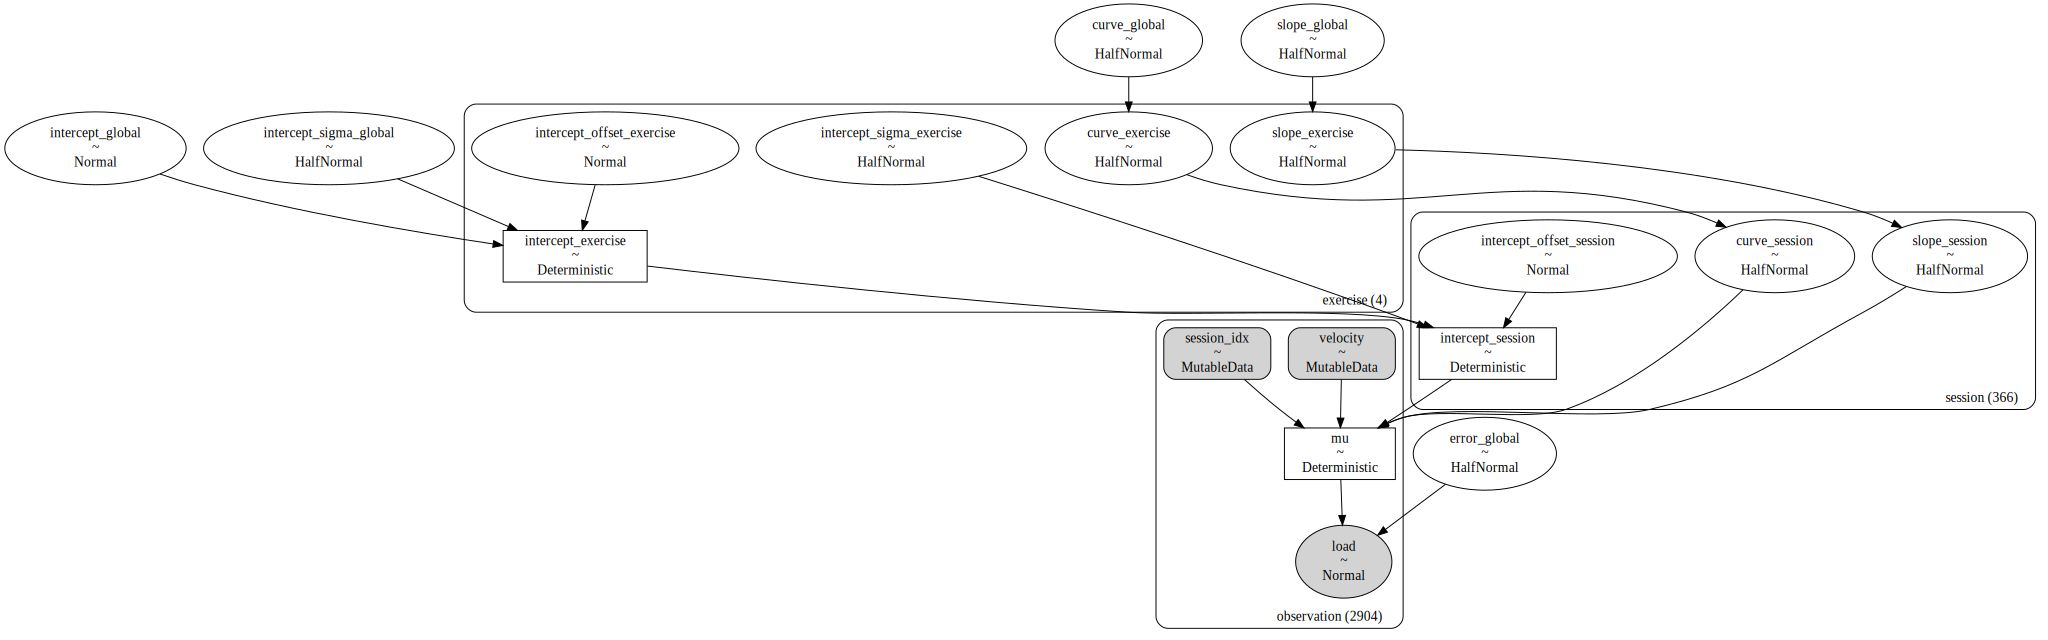

In [76]:
velocity_scaled = regr_data['velocity_scaled']
load_scaled = regr_data['load_scaled']
observation = regr_data['observation']

exercises = regr_data['exercise']
exercise_encoder = sklearn.preprocessing.LabelEncoder()
exercise_encoder.fit(exercises)

sessions = regr_data['session']
session_encoder = sklearn.preprocessing.LabelEncoder()
session_idx = session_encoder.fit_transform(sessions)

session_exercise = (regr_data.reset_index()[['session', 'exercise']]
                    .drop_duplicates()
                    .set_index('session', verify_integrity = True)
                    .sort_index()['exercise']
                    .values)

session_exercise_idx = exercise_encoder.transform(session_exercise)

coords = {'observation': observation,
          'exercise': exercise_encoder.classes_,
          'session': session_encoder.classes_}

model_data = {'velocity': velocity_scaled,
              'load': load_scaled,
              'session_idx': session_idx,
              'session_exercise_idx': session_exercise_idx,
              'coords': coords}

model = build_model(**model_data)

### Sample

In [77]:
inference_data = sample(model = model,
                        sampler = 'numpyro',
                        sampler_kwargs = {'target_accept': 0.98,
                                          'chains': n_devices,
                                          'progress_bar': False})
                        
inference_data

Compiling...
Compilation time =  0:01:23.872613
Sampling...
Sampling time =  1:16:06.145842
Transforming variables...
Transformation time =  0:00:03.489666
Computing Log Likelihood...
Log Likelihood time =  0:00:38.069307


Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

In [78]:
inference_path = inference_data.to_netcdf('pymc_inference_data.nc')

## Plot

### Trace

In [84]:
az.summary(inference_data,
           var_names = ['~mu', '~session', '~sigma', '~offset', 'intercept', 'slope', 'curve', 'error'],
           filter_vars = 'like',
           hdi_prob = hdi_prob)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept_global,-0.103,0.441,-0.816,0.619,0.005,0.003,8095.0,16185.0,1.01
slope_global,1.042,0.350,0.536,1.563,0.002,0.001,30440.0,42867.0,1.00
curve_global,0.080,0.055,0.027,0.132,0.000,0.000,28267.0,27390.0,1.00
error_global,0.110,0.002,0.107,0.112,0.000,0.000,24546.0,42881.0,1.00
slope_exercise[bench press],0.931,0.111,0.756,1.112,0.001,0.000,32273.0,45637.0,1.00
slope_exercise[deadlift],1.244,0.135,1.023,1.457,0.001,0.001,30939.0,44513.0,1.00
slope_exercise[overhead press],0.300,0.019,0.270,0.331,0.000,0.000,29161.0,45587.0,1.00
slope_exercise[squat],0.954,0.056,0.861,1.046,0.000,0.000,31986.0,47298.0,1.00
curve_exercise[bench press],0.004,0.004,0.000,0.009,0.000,0.000,711.0,891.0,1.09
curve_exercise[deadlift],0.007,0.007,0.000,0.016,0.000,0.000,565.0,651.0,1.13


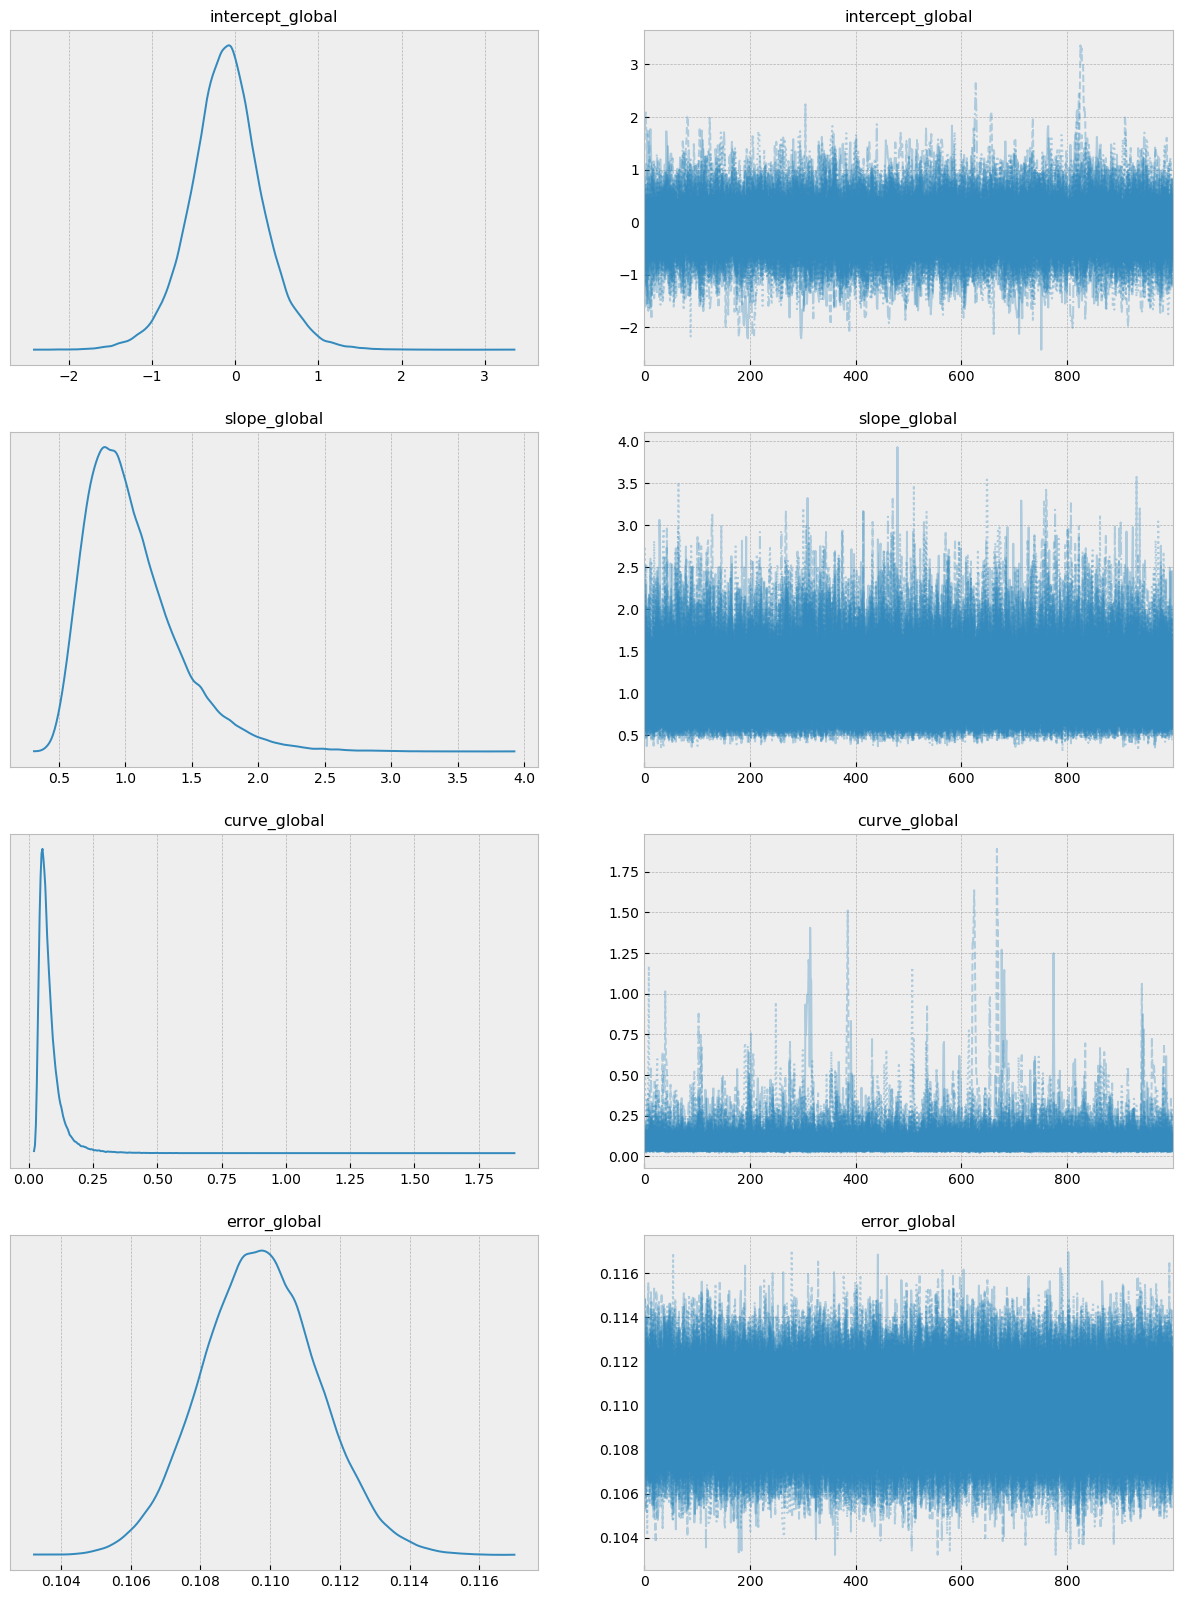

In [80]:
_ = az.plot_trace(inference_data,
                  compact = True,
                  combined = True,
                  figsize = [15, 20],
                  var_names = ['intercept_global', 'slope_global', 'curve_global', 'error_global'])

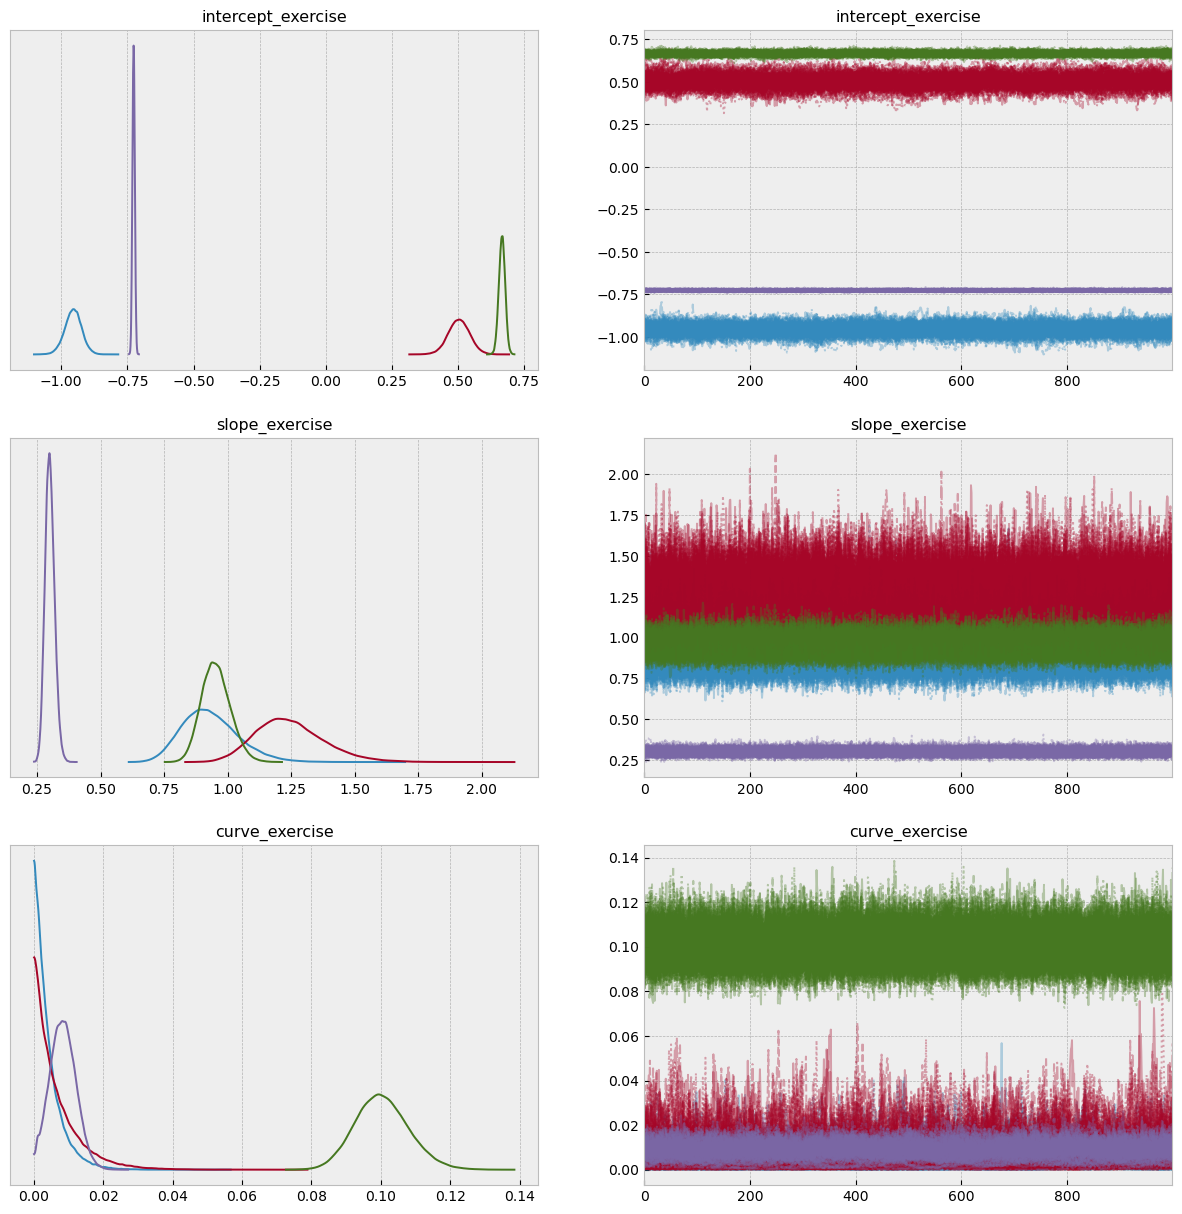

In [81]:
_ = az.plot_trace(inference_data,
                  compact = True,
                  combined = True,
                  figsize = [15, 15],
                  var_names = ['intercept_exercise', 'slope_exercise', 'curve_exercise'])

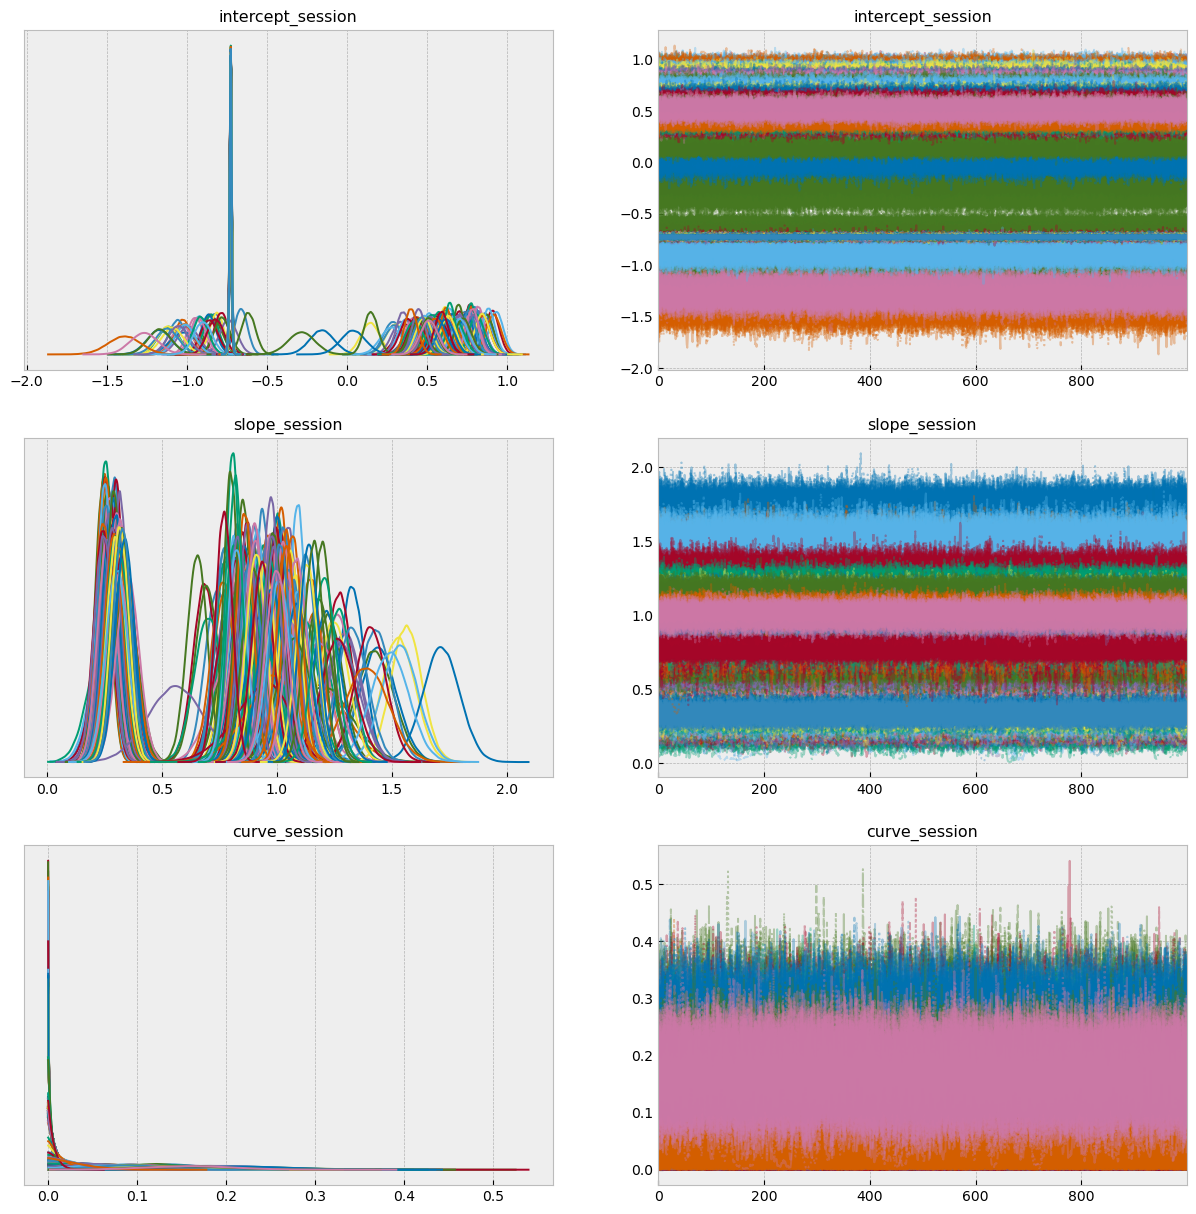

In [82]:
_ = az.plot_trace(inference_data,
                  compact = True,
                  combined = True,
                  figsize = [15, 15],
                  var_names = ['intercept_session', 'slope_session', 'curve_session'])

### Last Session Plot

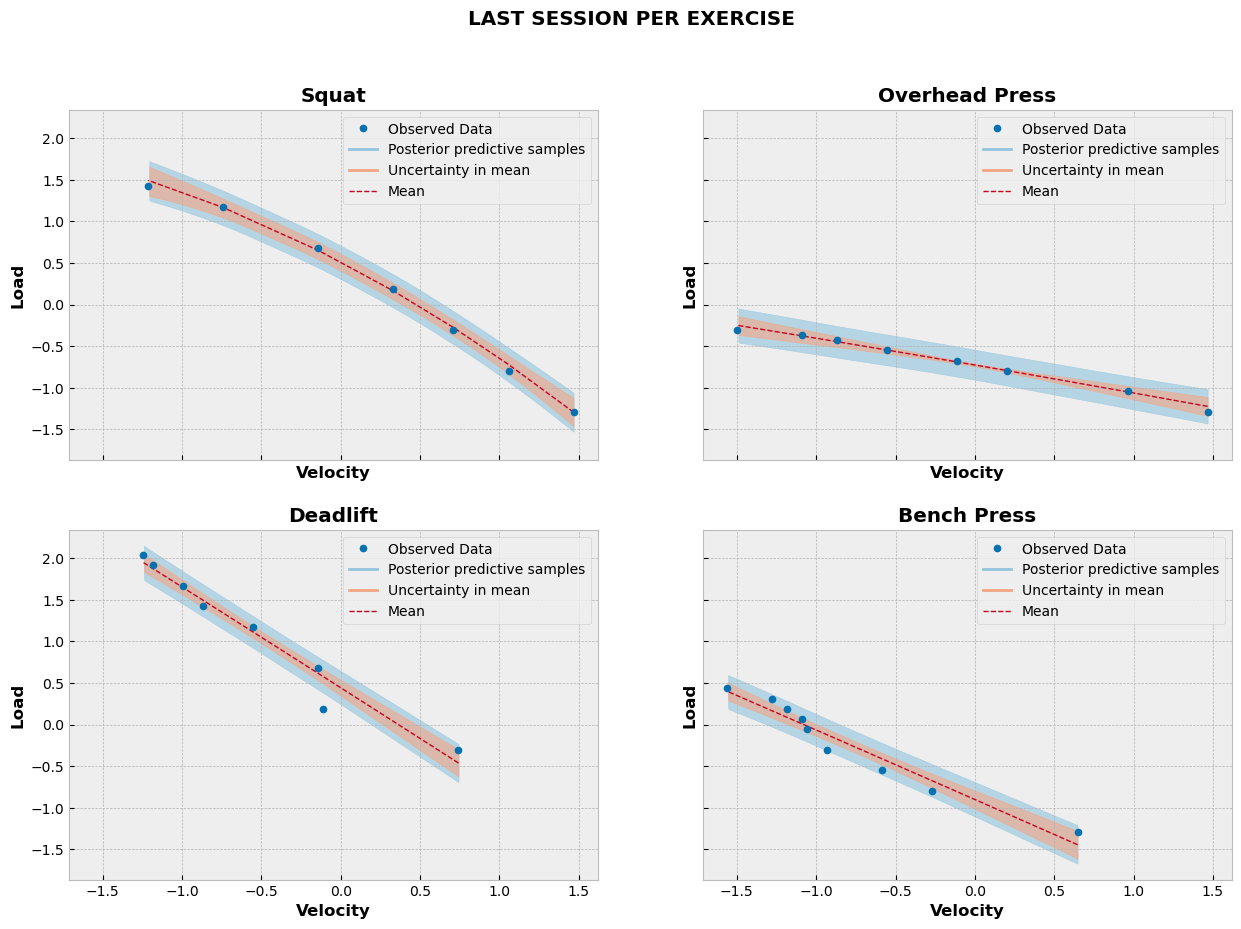

In [83]:
plot_last_session(exercises = ['squat', 'overhead press', 'deadlift', 'bench press'])

## Prediction

In [ ]:
velocity_min = 0
velocity_max = np.ceil(np.nanmax(ds['avg_velocity'])*10)/10
velocity_round = 0.01

velocity_pred = np.arange(velocity_min, velocity_max + velocity_round, velocity_round).round(2)
velocity_pred_scaled = velocity_scaler.transform(velocity_pred.reshape(-1, 1)).flatten()

session_idx_pred = np.full_like(velocity_pred, session_idx.max()).astype(int)

observation_pred = coords['observation'].max() + np.arange(len(velocity_pred)) + 1

with model as model_pred:
    pm.set_data(new_data = {'velocity': velocity_pred_scaled,
                            'session_idx': session_idx_pred},
                coords = {'observation': observation_pred})
    
    inference_data.extend(pm.sample_posterior_predictive(inference_data, predictions = True))

inference_data